# Distribution of User Contributions to the Relationship Task and User Accuracy

This code gives the distribution of user contributions to the completed RE task set and uses the QC'd annotations to estimate average accuracy of the users who did at least one task within the QC'd set. 

## Import modules and load data

In [1]:
import pandas
import matplotlib
from matplotlib import pyplot as mplot
import m2c_rel_basic
import relationship_dictionaries
from pandas import read_csv

Import the relationship annotations data for only completed concept pairs

In [2]:
savepath = 'data/'
exppath = 'results/'
all_completed_anns = read_csv(exppath+'all_completed_anns.txt', delimiter='\t', header=0)
all_completed_anns.drop("Unnamed: 0",axis=1,inplace=True)

Import the QC'd relation annotations and the relationship dictionaries

In [3]:
esample_df = m2c_rel_basic.get_QC_data(savepath)

In [4]:
rel_hash_dict,redundant_response_dict,abbreviated_rels_dict,abbreviated_rels_dict_4_hash,concept_broken_dict,concept_not_broken_dict = relationship_dictionaries.load_RE_dictionaries()

## Distribution of User Contributions to the set of completed relationship tasks
Get a count of the number of annotations submitted by each user, sort from highest number of contributions to lowest.

In [5]:
task_distribution = all_completed_anns.groupby(['user_id']).size().reset_index(name='anns_submitted')
task_distribution.sort_values('anns_submitted',ascending=False,inplace=True)
task_dist_results = task_distribution.reset_index(drop=True).copy()
task_dist_results['user_counts'] = task_dist_results.index.astype(int)+1
print('tasks completed: ',task_distribution.anns_submitted.sum())
print('users contributed: ',len(task_distribution))

tasks completed:  15739
users contributed:  147


Export the results for visualization in a graphing program, or visualize using matplotlib

In [6]:
### Export the user contribution distribution
#task_dist_results.to_csv(exppath+'task_distribution.txt', sep='\t', header=True)

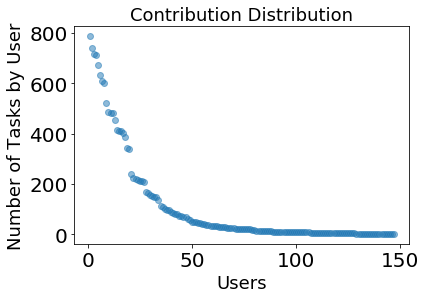

In [6]:
### Plot and visualize the user contribution distribution
plot_it = task_dist_results[['anns_submitted','user_counts']].copy()
mplot.scatter(x=plot_it['user_counts'], y=plot_it['anns_submitted'], alpha=0.5)
mplot.xlabel("Users", fontsize=18)
mplot.ylabel("Number of Tasks by User", fontsize=18)
mplot.title("Contribution Distribution", fontsize=18)
mplot.tick_params(axis='both', which='major', labelsize=20)
mplot.show()
#mplot.savefig(exppath+'contribution_distribution_lg_font.png', bbox_inches='tight', dpi=350)

Calculate the gini coefficient and distribution of effort metric.

In [7]:
gini_it = plot_it.copy()

## Determine the equation of the line under perfectly uniform contributions and calculate area under that line
slope = (gini_it['anns_submitted'].min()-gini_it['anns_submitted'].max())/(gini_it['user_counts'].max()-gini_it['user_counts'].min())
offset = gini_it['anns_submitted'].max()-(slope*1)
ideal_auc = 0.5*(gini_it['anns_submitted'].max()-gini_it['anns_submitted'].min())*(gini_it['user_counts'].max()-gini_it['user_counts'].min())

## Get shifted values
gini_it['anns_shift1'] = gini_it['anns_submitted'].shift(-1).fillna(0)
gini_it.drop(gini_it.index[len(gini_it)-1], inplace=True)

## Calculate area under distribution curve
gini_it['user_auc'] = 0.5*(gini_it['anns_submitted']+gini_it['anns_shift1'])*1
total_user_auc = gini_it.user_auc.sum()

## Calculate Distribution of Effort Metric and Gini Coefficient
effort_distribution = total_user_auc/ideal_auc
gini = 1-effort_distribution

print('Distribution of effort: ',effort_distribution, '| gini coefficient: ',gini)

Distribution of effort:  0.26743699675833943 | gini coefficient:  0.7325630032416606


## Calculate User Average Accuracy based on the QC'd set

In [8]:
## pull the tasks (cpmids) from the QC'd annotatin set
expert_cpmids = set(esample_df['cpmid'].tolist())

## Get the cpmids from the QC'd set and use it to generate the total user anns that are covered in the QC'd set (total_ref_set)
total_ref_set = all_completed_anns.loc[all_completed_anns['cpmid'].isin(expert_cpmids)].copy()

## Use dictionaries to deal with redundant responses
total_ref_set['evtype'].replace(abbreviated_rels_dict_4_hash, inplace=True)
total_ref_set['evtype'].replace(concept_broken_dict, inplace=True)
esample_df['conclusion'].replace(concept_broken_dict, inplace=True)

## get the list of users in the total_ref_set
user_set = set(total_ref_set['user_id'].unique().tolist())
user_max = len(user_set)

For each user in the user_set, pull the cpmids they did and match it to the QC'd set to create the test set. Calculate their accuracy and number of completions based on the test set and save it to a new df

In [9]:
checked_results = []
#print('checking ',user_max,' users and their annotations.')
for u in user_set:
    result_dict={}
    result_dict['user_id']=u
    test_set = total_ref_set[['cpmid','evtype']].loc[total_ref_set['user_id']==u]
    total_user_cpmid = len(all_completed_anns.loc[all_completed_anns['user_id']==u])
    limited_expert_cpmids = test_set['cpmid'].unique().tolist()
    ref_set = esample_df[['cpmid','conclusion']].loc[esample_df['cpmid'].isin(limited_expert_cpmids)].drop_duplicates(subset=['cpmid'], keep='first')
    ref_set['evtype'] = ref_set['conclusion']    
    ## Merge the dataframes to be able to quickly check if one column matches the other
    matches = ref_set.merge(test_set,on=(['cpmid','evtype']),how='inner')
    true_positive = len(matches)
    total_response = len(test_set)
    accuracy = true_positive/total_response
    result_dict['user_anns_checked']=len(test_set)
    result_dict['expert_anns_compared']=len(ref_set)
    result_dict['TP']=true_positive
    result_dict['total_response']=total_response
    result_dict['TN'] = total_response-true_positive
    result_dict['accuracy'] = accuracy
    result_dict['total_user_cpmid'] = total_user_cpmid
    checked_results.append(result_dict)    

user_checked_df = pandas.DataFrame(checked_results)

print(user_checked_df.head(n=2))

   TN  TP  accuracy  expert_anns_compared  total_response  total_user_cpmid  \
0   1   0  0.000000                     1               1                11   
1  13  22  0.628571                    35              35               339   

   user_anns_checked  user_id  
0                  1     1538  
1                 35     1540  


Calculate overall summary results

In [10]:
mean_accuracy = user_checked_df.accuracy.mean()
max_accuracy = user_checked_df.accuracy.max()
median_accuracy = user_checked_df.accuracy.median()
mean_error = user_checked_df.accuracy.sem()

print("mean: ",mean_accuracy," mean_error: ", mean_error)
print("max: ",max_accuracy, " median: ",median_accuracy)


mean:  0.5178380661016583  mean_error:  0.03046477683064259
max:  1.0  median:  0.6091269841269842


### Visualize Number of Tasks Done vs User Accuracy

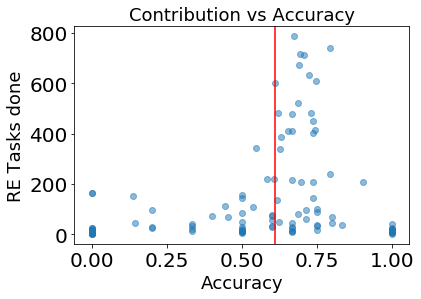

In [11]:
plot_it_B = user_checked_df[['user_id','total_user_cpmid','accuracy']].copy()
mplot.figure()
mplot.scatter(x=plot_it_B['accuracy'], y=plot_it_B['total_user_cpmid'], alpha=0.5)
mplot.xlabel("Accuracy", fontsize=18)
mplot.ylabel("RE Tasks done", fontsize=18)
mplot.title("Contribution vs Accuracy", fontsize=18)
mplot.axvline(median_accuracy, color='r')
mplot.tick_params(axis='both', which='major', labelsize=20)
mplot.show()
#mplot.savefig(exppath+'contribution_accuracy_lg_labels.png', bbox_inches='tight', dpi=350)

## Investigate ratio of discarded annotations and performance

Upon cursory inspection of users with 0% accuracy in spite of multiple annotations within the QC set, it appears that some users are reluctant to throw out concepts resulting in a lower performance.  To investigate this phenomena, obtain a count of the number of tasks each user did and the number of 'concept broken' responses each user submitted. Calculate the ratio of 'concept broken' to tasks submissions to look at tendency to throw away annotations

In [12]:
## Use dictionaries to deal with overly long and redundant responses from the completed relation task set
all_completed_anns['evtype'].replace(abbreviated_rels_dict_4_hash, inplace=True)
all_completed_anns['evtype'].replace(concept_broken_dict, inplace=True)

### Look at user willingness to throw away concept annotations vs user accuracy

In [13]:
tmp_user_set = set(user_checked_df['user_id'].tolist())
all_tmp_user_anns = all_completed_anns.loc[all_completed_anns['user_id'].isin(tmp_user_set)]
## subset out annotations these users marked as broken
tmp_broken_anns = all_tmp_user_anns.loc[all_tmp_user_anns['evtype']=='concept_broken']

## Get counts of number of annotations each user submitted vs 'broken' responses each user submitted
all_tmp_counts = all_completed_anns.groupby(['user_id']).size().reset_index(name='task_count')
broken_tmp_counts = tmp_broken_anns.groupby(['user_id']).size().reset_index(name='broken_count')
    
## Merge results back into the performance table
bk_reluctance_pf_df = user_checked_df.merge(broken_tmp_counts,on='user_id',how='left').fillna(0)
bk_reluctance_pf_df['broken_ratio'] = bk_reluctance_pf_df['broken_count'].div(bk_reluctance_pf_df['total_user_cpmid'])


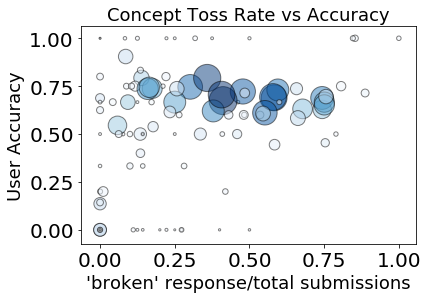

In [14]:
plot_these_results = bk_reluctance_pf_df.loc[bk_reluctance_pf_df['expert_anns_compared']>0]
tmpplotdata = plot_these_results[['accuracy','broken_ratio','user_anns_checked','total_user_cpmid']].copy()

mplot.scatter(x=tmpplotdata["broken_ratio"], y=tmpplotdata["accuracy"], s=tmpplotdata['total_user_cpmid'],c=tmpplotdata['user_anns_checked'],edgecolors='black', cmap="Blues", alpha=0.5)
mplot.xlabel("'broken' response/total submissions", fontsize=18)
mplot.ylabel("User Accuracy", fontsize=18)
mplot.title("Concept Toss Rate vs Accuracy", fontsize=18)
mplot.tick_params(axis='both', which='major', labelsize=20)
mplot.show()
#mplot.savefig(exppath+'concept_toss_accuracy_lg.png', bbox_inches='tight', dpi=300)

### Bin the results and get basic summary stats

In [15]:
## Binning Option 1: Get the accuracy value for the 20 percentile, 40 percentile, etc.
q1 = bk_reluctance_pf_df.accuracy.quantile(0.2)
q2 = bk_reluctance_pf_df.accuracy.quantile(0.4)
q3 = bk_reluctance_pf_df.accuracy.quantile(0.6)
q4 = bk_reluctance_pf_df.accuracy.quantile(0.8)

## bin results based on quantiles
bin_00 = bk_reluctance_pf_df.loc[(bk_reluctance_pf_df['accuracy']>=0) & (bk_reluctance_pf_df['accuracy']<q1)]
bin_02 = bk_reluctance_pf_df.loc[(bk_reluctance_pf_df['accuracy']>=q1) & (bk_reluctance_pf_df['accuracy']<q2)]
bin_04 = bk_reluctance_pf_df.loc[(bk_reluctance_pf_df['accuracy']>=q2) & (bk_reluctance_pf_df['accuracy']<q3)]
bin_06 = bk_reluctance_pf_df.loc[(bk_reluctance_pf_df['accuracy']>=q3) & (bk_reluctance_pf_df['accuracy']<q4)]
bin_08 = bk_reluctance_pf_df.loc[(bk_reluctance_pf_df['accuracy']>=q4) & (bk_reluctance_pf_df['accuracy']<1)]
bin_10 = bk_reluctance_pf_df.loc[(bk_reluctance_pf_df['accuracy']==1)]

bin_00.name = "bin_00"
bin_02.name = "bin_02"
bin_04.name = "bin_04"
bin_06.name = "bin_06"
bin_08.name = "bin_08"
bin_10.name = "bin_10"

perform_bins = (bin_00, bin_02, bin_04, bin_06, bin_08, bin_10)

In [24]:
## Binning Option 2: Bin results based on accuracy of 20%, 40%, etc.
bin_00 = bk_reluctance_pf_df.loc[(bk_reluctance_pf_df['accuracy']>=0) & (bk_reluctance_pf_df['accuracy']<0.2)]
bin_02 = bk_reluctance_pf_df.loc[(bk_reluctance_pf_df['accuracy']>=0.2) & (bk_reluctance_pf_df['accuracy']<0.4)]
bin_04 = bk_reluctance_pf_df.loc[(bk_reluctance_pf_df['accuracy']>=0.4) & (bk_reluctance_pf_df['accuracy']<0.6)]
bin_06 = bk_reluctance_pf_df.loc[(bk_reluctance_pf_df['accuracy']>=0.6) & (bk_reluctance_pf_df['accuracy']<0.8)]
bin_08 = bk_reluctance_pf_df.loc[(bk_reluctance_pf_df['accuracy']>=0.8) & (bk_reluctance_pf_df['accuracy']<1)]
bin_10 = bk_reluctance_pf_df.loc[(bk_reluctance_pf_df['accuracy']==1)]

bin_00.name = "bin_00"
bin_02.name = "bin_02"
bin_04.name = "bin_04"
bin_06.name = "bin_06"
bin_08.name = "bin_08"
bin_10.name = "bin_10"

perform_bins = (bin_00, bin_02, bin_04, bin_06, bin_08, bin_10)

In [16]:
## create a new dataframe to store updated results for ease of plotting
perf_result = []

for eachrange in perform_bins:
    ## get the mean, median, sem of performance, and broken ratio
    summ_stats = {
        'bin_range': eachrange.name,
        'accur_mean': eachrange.accuracy.mean(),
        'accur_median': eachrange.accuracy.median(),
        'accur_sem': eachrange.accuracy.sem(),
        'accur_std' : eachrange.accuracy.std(),
        'expert_anns_compared_sum' : eachrange.expert_anns_compared.sum(),
        'users_in_bin' : len(eachrange),
        'total_tasks_in_bin' : eachrange.total_user_cpmid.sum(),
        'broken_mean' : eachrange.broken_ratio.mean(),
        'broken_median' : eachrange.broken_ratio.median(),
        'broken_sem' : eachrange.broken_ratio.sem(),
        'broken_std' : eachrange.broken_ratio.std()
        }
    perf_result.append(summ_stats)

pref_results_df = pandas.DataFrame(perf_result)
print(pref_results_df)    

   accur_mean  accur_median  accur_sem  accur_std bin_range  broken_mean  \
0    0.000000      0.000000   0.000000   0.000000    bin_00     0.108550   
1    0.292629      0.333333   0.032568   0.112820    bin_02     0.202235   
2    0.559246      0.564394   0.010699   0.056613    bin_04     0.352748   
3    0.698213      0.691261   0.005874   0.029953    bin_06     0.389738   
4    0.788535      0.792683   0.014536   0.048209    bin_08     0.206107   
5    1.000000      1.000000   0.000000   0.000000    bin_10     0.381129   

   broken_median  broken_sem  broken_std  expert_anns_compared_sum  \
0       0.000000    0.031056    0.148937                        74   
1       0.117568    0.073959    0.256203                        89   
2       0.357249    0.046386    0.245452                       461   
3       0.409211    0.051365    0.261912                       964   
4       0.135135    0.066249    0.219724                       168   
5       0.284091    0.100299    0.347447       

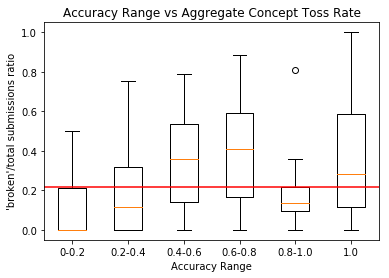

In [17]:
### Clean up the data and plot it

data = (bin_00['broken_ratio'], bin_02['broken_ratio'], bin_04['broken_ratio'], bin_06['broken_ratio'], bin_08['broken_ratio'], bin_10['broken_ratio'])

mplot.figure()
mplot.boxplot(data)
mplot.xticks([1, 2, 3, 4, 5, 6], ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0','1.0'])
mplot.xlabel("Accuracy Range")
mplot.ylabel("'broken'/total submissions ratio")
mplot.axhline(bk_reluctance_pf_df.broken_ratio.median(), color='r')
mplot.title("Accuracy Range vs Aggregate Concept Toss Rate")
mplot.show()
#mplot.savefig(exppath+'toss_rate_binned_by_accuracy.png', bbox_inches='tight', dpi=300)
#mplot.savefig(exppath+'toss_rate_binned_by_performance quintiles.png', bbox_inches='tight', dpi=300)

### See how accuracy changes if users with concept toss rates of 0 are removed

mean:  0.5898425298200561  mean_error:  0.029288370052264767
max:  1.0  median:  0.6594202898550725


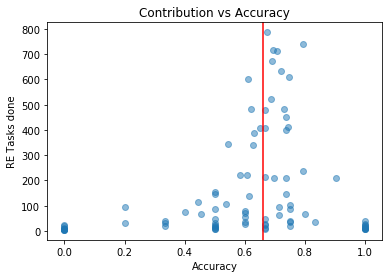

In [21]:
## Inspect accuracy after adjusting for users who don't toss concepts
nontossers = bk_reluctance_pf_df.loc[bk_reluctance_pf_df['broken_ratio']<=0]

plot_it_C = user_checked_df[['user_id','total_user_cpmid','accuracy']].loc[~user_checked_df['user_id'].isin(nontossers['user_id'])].copy()

mean_accuracy_adj = plot_it_C.accuracy.mean()
max_accuracy_adj = plot_it_C.accuracy.max()
median_accuracy_adj = plot_it_C.accuracy.median()
mean_error_adj = plot_it_C.accuracy.sem()

print("mean: ",mean_accuracy_adj," mean_error: ", mean_error_adj)
print("max: ",max_accuracy_adj, " median: ",median_accuracy_adj)

mplot.figure()
mplot.scatter(x=plot_it_C['accuracy'], y=plot_it_C['total_user_cpmid'], alpha=0.5)
mplot.xlabel("Accuracy")
mplot.ylabel("RE Tasks done")
mplot.title("Contribution vs Accuracy")
mplot.axvline(median_accuracy_adj, color='r')
mplot.show()
#mplot.savefig(exppath+'contribution_accuracy_less_nontossers.png', bbox_inches='tight', dpi=300)

In [24]:
### export list of reluctant concept tossers
#nontoss = nontossers.to_csv(exppath+'concept_nontossers.txt',sep='\t',header=True)
